In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from scipy import stats
from utils.notebook_config import *
import random
from utils.simulation import *

In [2]:
#Work here with the defined classes in simulation2.py

n = 5

p1, m_on, m_off = 0.1, 0.01, 0.01

# gene1 = gene(3, boxes, p1, p2)
# gene2 = gene(3, boxes, p1, p2)

steps = 3000

shots = 1000

simu = simulation(timesteps=steps)

avg1, std1, avg2, std2, corr, corrx = simu.average(n, p1, m_on, m_off, shots, m_switch=False)
avg1m, std1m, avg2m, std2m, corrm, corrxm = simu.average(n, p1, m_on, m_off, shots, m_switch=True)

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [3]:
mod_corrx, mod_corrxm = corrx.T, corrxm.T

np.shape(mod_corrx)  #          #timewindows x #shots

(2427, 1000)

In [4]:
#Check for nan, no nan ==> notnice = 0

notnice = 0

nice = 0

for i in mod_corrx.flatten():
    if i == 100:
        notnice += 1
    else:
        nice += 1

print(notnice)

print(nice)

0
2427000


In [5]:
avg_corr = 0
for i in range(np.shape(mod_corrx)[0]):
    corr1 = mod_corrx[:][i]
    corrm1 = mod_corrxm[:][i]
    corr1 = [i for i in corr1 if i != 100]
    corrm1 = [i for i in corrm1 if i != 100]

    hmm_corr1 = [i for i in corr1 if np.abs(i)>0]
    hmm_corrm1 = [i for i in corrm1 if np.abs(i)>0]

    avg_corr += np.mean(hmm_corr1+hmm_corrm1)
avg_corr = avg_corr/np.shape(mod_corrx)[0]

print(avg_corr)

0.0014375212371895518


Mean + std. (static):  -0.00027550739894933996  +-  0.2161701948238212
Mean + std. (dyn.):  -0.0016474762021000044  +-  0.21626861862788557


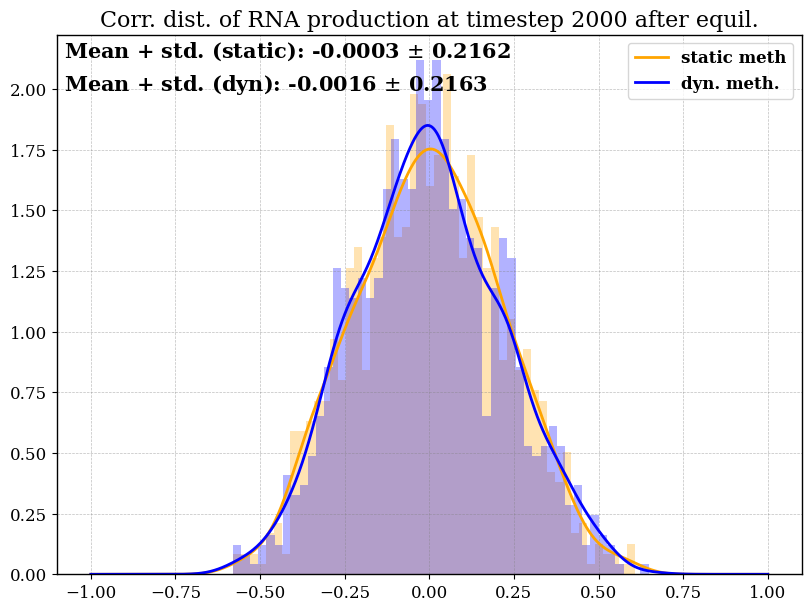

In [11]:
mod_corrx, mod_corrxm = corrx.T, corrxm.T

time = 2000

corr1 = mod_corrx[:][time]
corrm1 = mod_corrxm[:][time]

hmm_corr1 = [i for i in corr1 if np.abs(i)>0]
hmm_corrm1 = [i for i in corrm1 if np.abs(i)>0]

m1, std1 = np.mean(hmm_corr1), np.std(hmm_corr1)
print("Mean + std. (static): ", m1, " +- ", std1)

m2, std2 = np.mean(hmm_corrm1), np.std(hmm_corrm1)
print("Mean + std. (dyn.): ", m2, " +- ", std2)

kde = stats.gaussian_kde(hmm_corr1)

kde_m = stats.gaussian_kde(hmm_corrm1)

xx = np.linspace(-1,1, 1000)
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(hmm_corr1, density=True, bins=50, alpha=0.3, color="orange")
ax.hist(hmm_corrm1, density=True, bins=50, alpha=0.3, color="blue")
ax.plot(xx, kde(xx), label="static meth", color="orange")
ax.plot(xx, kde_m(xx), label="dyn. meth.", color="blue")

kwargs = {"ha":"left", "va":"top", "transform":ax.transAxes, "fontsize":15, "fontweight":"bold"}

ax.text(0.01, 0.99, r"Mean + std. (static): {} $\pm$ {}".format(round(m1,4), round(std1,4)), kwargs)
ax.text(0.01, 0.93, r"Mean + std. (dyn): {} $\pm$ {}".format(round(m2,4), round(std2,4)), kwargs)

# ax.hist(hmm_corr1+hmm_corrm1, density=True, bins=50, alpha=0.3, color="red")
# ax.plot(xx, (kde(xx)+kde_m(xx))/2, label="all", color="red")

plt.legend(prop={'weight': "bold"})
plt.title("Corr. dist. of RNA production at timestep {} after equil.".format(time))
#plt.savefig("figures/corr50.png", dpi=300)
plt.show()

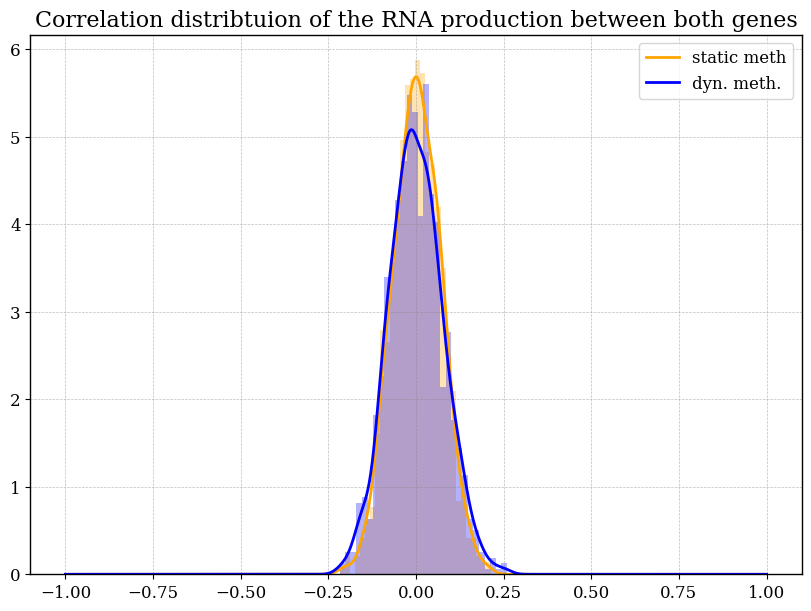

In [7]:
corrm1 = [i for i in corrm if i != 0]

corr1 = [i for i in corr if i != 0]

kde = stats.gaussian_kde(corr1)

kde_m = stats.gaussian_kde(corrm1)

xx = np.linspace(-1,1, 1000)
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(corr1, density=True, bins=30, alpha=0.3, color="orange")
ax.hist(corrm1, density=True, bins=30, alpha=0.3, color="blue")
ax.plot(xx, kde(xx), label="static meth", color="orange")
ax.plot(xx, kde_m(xx), label="dyn. meth.", color="blue")
plt.legend()
plt.title("Correlation distribtuion of the RNA production between both genes")
#plt.savefig("figures/corr1.png", dpi=300)
plt.show()

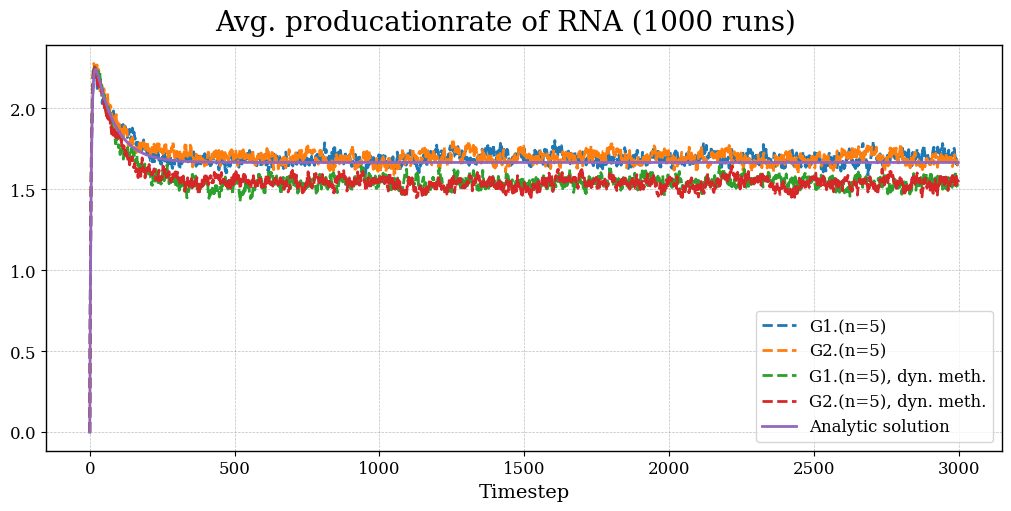

In [12]:
def analytic(length: int, p_on:float, p_off: float, timesteps: int):
    x = [i for i in range(timesteps)]
    y = []
    for i in x:
        solution = length*(p_on/(p_on+p_off))*(1-np.exp(-(p_off+p_on)*i))
        y.append(solution)

    return x,y

def analytic_meth(length: int, p_on:float, p_off: float, m_on: float, m_off: float, timesteps: int):        #constant methylation rate!
    x = [i for i in range(timesteps)]
    y = []
    k, m = p_on+p_off, m_on+m_off

    a = p_on*(m-m_on)
    b = -k*m + m_on*p_on
    c = m + k
    g_1, g_2 = (-c+np.sqrt(c**2+4*b))/2, (-c-np.sqrt(c**2+4*b))/2
    c_1 = ((g_2*a - p_on*b)/(b*(g_2-g_1)))
    for i in x:
        theta = c_1*np.exp(g_1*i) + (a/b - c_1)*np.exp(g_2*i) - a/b
        solution = length*theta
        y.append(solution)
    return x,y

time = simu.timeline

x,y = analytic_meth(n, p_on=p1, p_off=p1, m_on=m_on, m_off=m_off, timesteps = steps)

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(time, avg1, label="G1.(n={})".format(n), linestyle="--")
ax1.plot(time, avg2, label="G2.(n={})".format(n), linestyle="--")

ax1.plot(time, avg1m, label="G1.(n={}), dyn. meth.".format(n), linestyle="--")
ax1.plot(time, avg2m, label="G2.(n={}), dyn. meth.".format(n), linestyle="--")

ax1.plot(x,y, label="Analytic solution")

ax1.set_xlabel("Timestep")
# ax1.set_title("Avg. producationrate of protein (1000 shots)")
# ax2.set_title("Avg. producationrate of protein (1000 shots)")
plt.suptitle("Avg. producationrate of RNA (1000 runs)", fontsize=20)
plt.legend()
#plt.savefig("figures/rna1.png", dpi = 300)
plt.show()

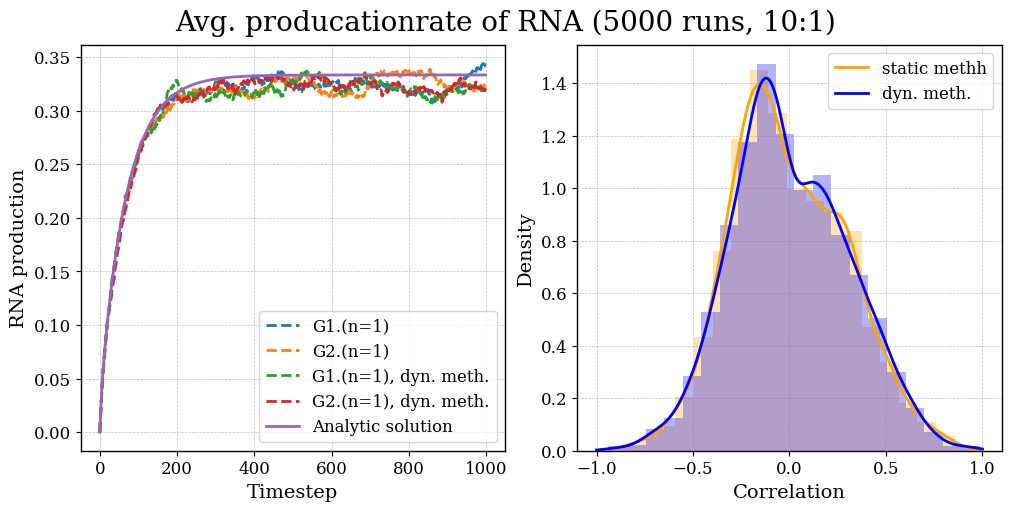

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.plot(time, avg1, label="G1.(n={})".format(n), linestyle="--")
ax1.plot(time, avg2, label="G2.(n={})".format(n), linestyle="--")

ax1.plot(time, avg1m, label="G1.(n={}), dyn. meth.".format(n), linestyle="--")
ax1.plot(time, avg2m, label="G2.(n={}), dyn. meth.".format(n), linestyle="--")

ax1.plot(x,y, label="Analytic solution")

ax1.set_xlabel("Timestep")
ax1.set_ylabel("RNA production")

ax1.legend()

ax2.hist(corr1, density=True, bins=20, alpha=0.3, color="orange")
ax2.hist(corrm1, density=True, bins=20, alpha=0.3, color="blue")
ax2.plot(xx, kde(xx), label="static methh", color="orange")
ax2.plot(xx, kde_m(xx), label="dyn. meth.", color="blue")
ax2.set_xlabel("Correlation")
ax2.set_ylabel("Density")
ax2.legend()

# ax1.set_title("Avg. producationrate of protein (1000 shots)")
# ax2.set_title("Avg. producationrate of protein (1000 shots)")
plt.suptitle("Avg. producationrate of RNA ({} runs, 10:1)".format(shots), fontsize=20)
#plt.savefig("figures/corr3.png", dpi = 300)
plt.show()

In [ ]:
n = 50

p1, m_on, m_off = 0.2, 0.05, 0.05

simu = simulation(timesteps=200)

avg1_n, std1_n, avg2_n, std2_n, corr_n = simu.average(n, p1, m_on, m_off, 1000, m_switch=False)
avg1m_n, std1m_n, avg2m_n, std2m_n, corrm_n = simu.average(n, p1, m_on, m_off, 1000, m_switch=True)

In [21]:
max_len = len(avg1_n)

def pad_list(lst, length):
    return lst + [0] * (length - len(lst))

corr_n_padded = pad_list(corr_n, max_len)
corrm_n_padded = pad_list(corrm_n, max_len)

cols = ["avg1", "std1", "avg2", "std2", "corr", 
        "avg1m", "std1m", "avg2m", "std2m", "corrm"]
header = "time\t" + "\t".join(f"{c}_{n}" for c in cols)

data_n = np.column_stack((simu.timeline, avg1_n, std1_n, avg2_n, std2_n, corr_n_padded
                          , avg1m_n, std1m_n, avg2m_n, std2m_n, corrm_n_padded ))

np.savetxt("data/length{}.txt".format(n), data_n, fmt="%f", header=header, delimiter="\t")

In [5]:
data = np.loadtxt("data/length10.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_10    = data[:, 1]
std1_10    = data[:, 2]
avg2_10    = data[:, 3]
std2_10    = data[:, 4]
corr_10 = data[:100, 5]

avg1m_10    = data[:, 6]
std1m_10    = data[:, 7]
avg2m_10    = data[:, 8]
std2m_10    = data[:, 9]
corrm_10 = data[:100, 10]


data = np.loadtxt("data/length30.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_30    = data[:, 1]
std1_30    = data[:, 2]
avg2_30    = data[:, 3]
std2_30    = data[:, 4]
corr_30 = data[:100, 5]

avg1m_30    = data[:, 6]
std1m_30    = data[:, 7]
avg2m_30    = data[:, 8]
std2m_30    = data[:, 9]
corrm_30 = data[:100, 10]


data = np.loadtxt("data/length50.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_50    = data[:, 1]
std1_50    = data[:, 2]
avg2_50    = data[:, 3]
std2_50    = data[:, 4]
corr_50 = data[:100, 5]

avg1m_50    = data[:, 6]
std1m_50    = data[:, 7]
avg2m_50    = data[:, 8]
std2m_50    = data[:, 9]
corrm_50 = data[:100, 10]

# data = np.loadtxt("data/length100_corr.txt", delimiter="\t", skiprows=1)

# time       = data[:, 0]
# avg1_100    = data[:, 1]
# std1_100   = data[:, 2]
# avg2_100    = data[:, 3]
# std2_100    = data[:, 4]
# corr_100 = data[:100, 5]

# avg1m_100    = data[:, 6]
# std1m_100   = data[:, 7]
# avg2m_100   = data[:, 8]
# std2m_100    = data[:, 9]
# corrm_100 = data[:100, 10]

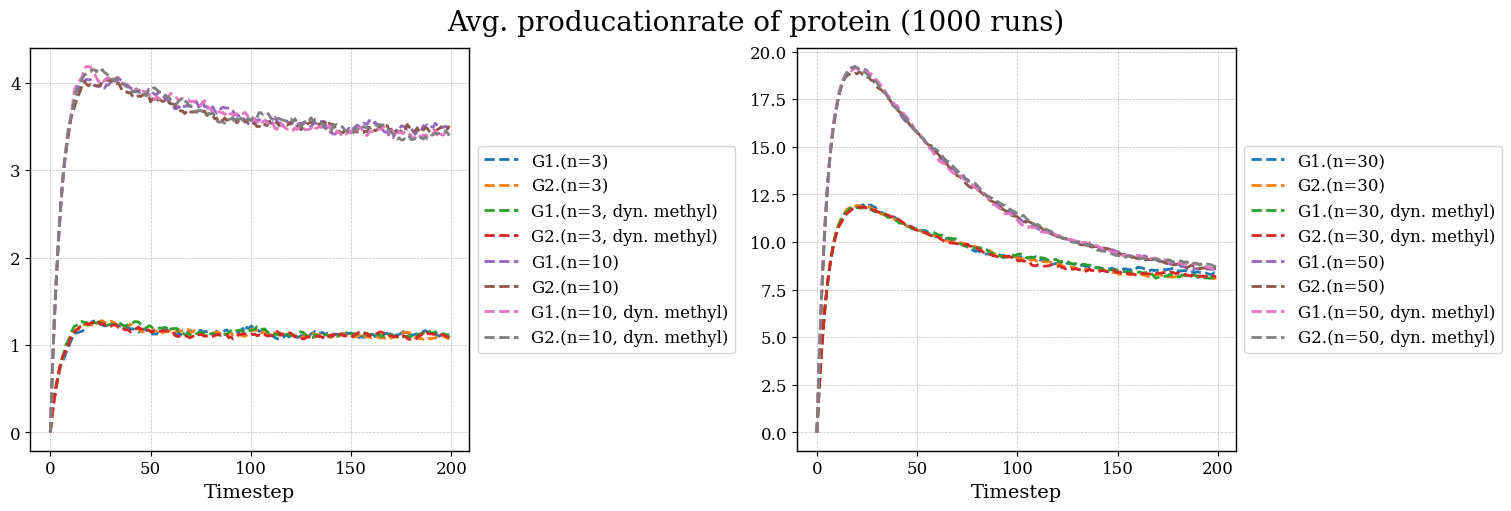

For 3 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.08535089536426471
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.04476683423206664

 For 10 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.08718350000000001
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.10124534

 For 30 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.26387796999999996
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.27688848000000005

 For 50 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.57338773
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.56790551


In [6]:
time = simu.timeline

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))


ax1.plot(time, avg1, label="G1.(n=3)", linestyle="--")
ax1.plot(time, avg2, label="G2.(n=3)", linestyle="--")

ax1.plot(time, avg1m, label="G1.(n=3, dyn. methyl)", linestyle="--")
ax1.plot(time, avg2m, label="G2.(n=3, dyn. methyl)", linestyle="--")

ax1.plot(time, avg1_10, label="G1.(n=10)", linestyle="--")
ax1.plot(time, avg2_10, label="G2.(n=10)", linestyle="--")

ax1.plot(time, avg1m_10, label="G1.(n=10, dyn. methyl)", linestyle="--")
ax1.plot(time, avg2m_10, label="G2.(n=10, dyn. methyl)", linestyle="--")

ax2.plot(time, avg1_30, label="G1.(n=30)", linestyle="--")
ax2.plot(time, avg2_30, label="G2.(n=30)", linestyle="--")

ax2.plot(time, avg1m_30, label="G1.(n=30, dyn. methyl)", linestyle="--")
ax2.plot(time, avg2m_30, label="G2.(n=30, dyn. methyl)", linestyle="--")

ax2.plot(time, avg1_50, label="G1.(n=50)", linestyle="--")
ax2.plot(time, avg2_50, label="G2.(n=50)", linestyle="--")

ax2.plot(time, avg1m_50, label="G1.(n=50, dyn. methyl)", linestyle="--")
ax2.plot(time, avg2m_50, label="G2.(n=50, dyn. methyl)", linestyle="--")

# ax2.plot(time, avg1_100, label="G1.(n=100)", linestyle="--")
# ax2.plot(time, avg2_100, label="G2.(n=100)", linestyle="--")

# ax2.plot(time, avg1m_100, label="G1.(n=100, dyn. methyl)", linestyle="--")
# ax2.plot(time, avg2m_100, label="G2.(n=100, dyn. methyl)", linestyle="--")

ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
# ax1.set_title("Avg. producationrate of protein (1000 shots)")
# ax2.set_title("Avg. producationrate of protein (1000 shots)")
plt.suptitle("Avg. producationrate of protein (1000 runs)", fontsize=20)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figures/plot1.pdf")
plt.show()

print("For 3 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ", np.mean(corr))
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ",  np.mean(corrm))

print("\n For 10 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ",  np.mean(corr_10))
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ",  np.mean(corrm_10))

print("\n For 30 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ",  np.mean(corr_30))
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ",  np.mean(corrm_30))

print("\n For 50 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ",  np.mean(corr_50))
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ",  np.mean(corrm_50))

# print("\n For 100 lattice sites:\n")
# print("Avg. Correlation bewteen the protein prodcution of each gene: ", corr_100)
# print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ", corrm_100)

MEthylazsation based on avergae methylzation   --> Check

Off methylazation is constant       --> Check

Check analytic solution and compare for one box first  --> Check (no methylation)

Off box prob is likely a bit higher than one (can ignore for now)

dont take average of corr, plot histrogramm of all the runs, look at variance     --> Check

In the limit where the rate for on/off is similar to timescale, we should see pseudo correlation

Also tweak the mehtylataion rate in a regime, where one gene might become fully methylated --> possible high correlation!